# Dashboards

As a data scientist, you may find yourself needing to create a *dashboard*, a website with plots created automatically as new data arrives or the user interacts with the site in various ways.

We'll learn how to create flask applications that can return responses with content other than HTML (for example, SVG images); then we'll use that to create a page with some plots.

In this reading (as before), we'll run our flask applications directly from our notebook.  Remember that this as a strange use case that only makes sense if you're writing documentation.  In real use cases, you'll write your flask applications in .py files.

## Preliminary Setup

As in previous readings, we'll have some helper code for a selenium client that will visit our flask application (showing us either the source code or a screenshot)...

In [1]:
import time
import requests
from IPython.core.display import Image
from multiprocessing import Process
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import NoSuchElementException

options = Options()
options.headless = True
b = webdriver.Chrome(options=options)

def visit(url, source=False, height=400):
    if source:
        r = requests.get(url)
        return r.text
    else:
        b.set_window_size(600, height=height)
        b.get(url)
        b.save_screenshot("tmp.png")
        return Image("tmp.png")

## Flask Response Objects

We can use the flask module to create a *server*, and we can use the requests module to create a *client* that sends requests to a server (flask or otherwise).

When the requests module sends a request, it gets a requests `Response` object back (of type `requests.models.Response`, to be precise).  Confusingly, flask also has a class named `Response` (`flask.wrappers.Response`).  When a flask handler function returns a string (as in all our earlier examples this semester), flask actually converts that to a flask Response object.  We can also create the flask Response object ourselves, which provides some additional flexibility.  We'll do this in the following example, which will also involve a requests Response object; just remember these are two different types in different frameworks that happen to have the same name.

Let's create a simple app with two routes, "/" and "/divide.json".  The former returns a string (which Flask converts to a Response object); the latter explicitly creates the Response object.

In [2]:
from flask import Flask, request, Response
import json

app1 = Flask("example-server")

@app1.route("/")
def home():
    return """
    <html>
    <body>
    <h1>Hello!</h1>
    </body>
    </html>
    """

@app1.route("/divide.json")
def div():
    numerator = float(request.args["numerator"])
    denominator = float(request.args["denominator"])
    d = {"num": numerator,
         "denom": denominator}
    if denominator == 0:
        status_code = 500
        d["result"] = None
        d["error"] = "denominator cannot be zero!!!"
    else:
        status_code = 200
        d["result"] = numerator/denominator

    return Response(json.dumps(d),
                    headers={"Content-Type": "application/json"},
                    status=status_code)

p = Process(target=app1.run)
p.start()
time.sleep(1) # give it time to get going

 * Serving Flask app "example-server" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [26/Feb/2021 09:35:22] "GET /divide.json?numerator=1&denominator=2 HTTP/1.1" 200 -
127.0.0.1 - - [26/Feb/2021 09:35:22] "GET /divide.json?numerator=2&denominator=0 HTTP/1.1" 500 -
127.0.0.1 - - [26/Feb/2021 09:35:22] "GET / HTTP/1.1" 200 -


Let's send a request to "/divide.json", with some arguments passed in the query string.

In [3]:
r = requests.get("http://127.0.0.1:5000/divide.json?numerator=1&denominator=2")
print(r.text)

{"num": 1.0, "denom": 2.0, "result": 0.5}


In addition to that text we got back (the *body* of the response), the response also contains a status code and some *metadata* in a *header* that describes the data in the body of the response.

In [4]:
r.status_code # 200 is the code for success in HTTP

200

In [5]:
r.headers # a dictionary with info about the content in the body

{'Content-Type': 'application/json', 'Content-Length': '41', 'Server': 'Werkzeug/0.14.1 Python/3.7.2', 'Date': 'Fri, 26 Feb 2021 15:35:22 GMT'}

Some of those response headers were automatically generated by flask, but the `'Content-Type': 'application/json'` part came from this snippet in the above flask code:

```python
    return Response(json.dumps(d),
                    headers={"Content-Type": "application/json"},
                    status=status_code)
```

It's helpful for clients to have this additional status and type information beyond just the raw text in the body.  In other cases, we might get useful text back, but a status code will tell us something still went wrong.  Let's see this by dividing by zero:

In [6]:
r = requests.get("http://127.0.0.1:5000/divide.json?numerator=2&denominator=0")
r.text

'{"num": 2.0, "denom": 0.0, "result": null, "error": "denominator cannot be zero!!!"}'

In [7]:
r.status_code

500

500 means "Internal Server Error" in HTTP, which makes sense: https://developer.mozilla.org/en-US/docs/Web/HTTP/Status/500

Note that in many cases, we'll use `r.raise_for_status()` to trigger an exception when the status code is not 200.  Here, we didn't do that because we wanted to see the specific text returned, even though their was an error status (HTTP 500).

Remember that the home page (route "/") just returns a string.  Flask assumes this means the request was successful (status 200) and that the type is "text/html".

In [8]:
r = requests.get("http://127.0.0.1:5000")
print(r.text)


    <html>
    <body>
    <h1>Hello!</h1>
    </body>
    </html>
    


In [9]:
r.status_code

200

In [10]:
r.headers

{'Content-Type': 'text/html; charset=utf-8', 'Content-Length': '71', 'Server': 'Werkzeug/0.14.1 Python/3.7.2', 'Date': 'Fri, 26 Feb 2021 15:35:22 GMT'}

Note: in the first example we were working with JSON data in a somewhat cumbersome way (to make it more clear what is happening).  Both flask and the requests module have functions/methods for removing some of the steps involved in working with JSON data.  We won't discuss those here, but here are some additional docs for those interested:

https://flask.palletsprojects.com/en/1.1.x/api/#flask.json.jsonify

https://requests.readthedocs.io/en/master/user/quickstart/#json-response-content

In [11]:
p.terminate()

## SVG Images

SVG is a common image format used on the web.  Anything we make with pandas/matplotlib can be saved as on SVG.

We'll generate some random example data (about animal sightings) for some plots.

In [12]:
%matplotlib inline

In [13]:
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16

Text(0, 0.5, 'Bear Sightings')

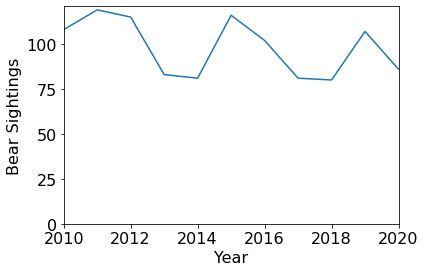

In [14]:
import numpy as np
import pandas as pd

df = pd.DataFrame({
    "Bear": np.random.randint(80, 120, size=12),
    "Deer": np.random.randint(700, 1100, size=12),
    "Wolf": np.random.randint(20, 30, size=12),
}, index=list(range(2010, 2022)))
ax = df["Bear"].plot.line(ylim=0, xlim=(2010, 2020))
ax.set_xlabel("Year")
ax.set_ylabel("Bear Sightings")

Let's save that above plot to a file names "bears.svg":

In [15]:
ax.get_figure().savefig("bears.svg")

The following contains two example flask handlers that return SVG files.  Note that they inform clients about this type by setting the `Content-Type` to `image/svg+xml` in the response headers.  A common misconception is that clients determine the type by looking at the extension (the ".svg" part of "/bears.svg"), but they actually do this by looking at the "Content-Type".  It would be strange, but you could actually have a route named "bears.html" with a handler that returns content type of "SVG" (browsers would treat this as an SVG, ignoring the ".html" extension).

In the first example, the contents are obtained by reading that "bears.svg" file we just created in the cell above.

In [16]:
from io import BytesIO

app2 = Flask("example-server")

@app2.route("/bears.svg")
def bears():
    with open("bears.svg") as f:
        return Response(f.read(),
                        headers={"Content-Type": "image/svg+xml"})

@app2.route("/animal.svg")
def animal():
    fig, ax = plt.subplots()

    animal = request.args["type"]
    df[animal].plot.line(ylim=0, xlim=(2010, 2020), ax=ax)
    ax.set_xlabel("Year")
    ax.set_ylabel(f"{animal} Sightings")
    fake_file = BytesIO()
    ax.get_figure().savefig(fake_file, format="svg", bbox_inches="tight")
    return Response(fake_file.getvalue(),
                    headers={"Content-Type": "image/svg+xml"})

p = Process(target=app2.run)
p.start()
time.sleep(1) # give it time to get going

 * Serving Flask app "example-server" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [26/Feb/2021 09:35:24] "GET /bears.svg HTTP/1.1" 200 -
127.0.0.1 - - [26/Feb/2021 09:35:24] "GET /bears.svg HTTP/1.1" 200 -
127.0.0.1 - - [26/Feb/2021 09:35:25] "GET /animal.svg?type=Deer HTTP/1.1" 200 -
127.0.0.1 - - [26/Feb/2021 09:35:25] "GET /animal.svg?type=Wolf HTTP/1.1" 200 -


The contents of an SVG file is just text, that actually looks somewhat similar to HTML:

In [17]:
print(visit("http://127.0.0.1:5000/bears.svg", source=True)[:500])

<?xml version="1.0" encoding="utf-8" standalone="no"?>
<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN"
  "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">
<!-- Created with matplotlib (https://matplotlib.org/) -->
<svg height="288pt" version="1.1" viewBox="0 0 432 288" width="432pt" xmlns="http://www.w3.org/2000/svg" xmlns:xlink="http://www.w3.org/1999/xlink">
 <defs>
  <style type="text/css">
*{stroke-linecap:butt;stroke-linejoin:round;}
  </style>
 </defs>
 <g id="figure_1">
  <g id="patch_1"


Browsers understand how to create an image based on that text:

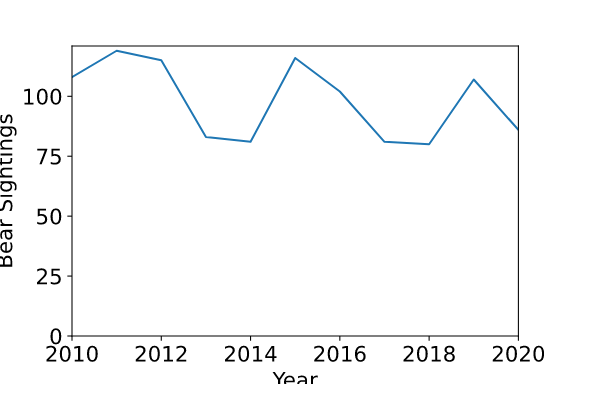

In [18]:
visit("http://127.0.0.1:5000/bears.svg")

In the second example ("/animal.svg" route), we want to make a different plot, based on the type of animal requested in the query string: `request.args["type"]`.

`ax.get_figure().savefig(...)` normally saves a file with the contents of the SVG.  We could do that like normal, then read it back as a string that the handler returns.

But this seems a bit indirect.  Wouldn't it be nice if we could directly "save" the SVG file to the string we'll use instead of creating a new file first?

`BytesIO` solves this problem.  An object of type `BytesIO` is what we call a *file-like object* in Python, meaning you can read and write to it as if it were a file, but no actual file is ever created.  You can think of it as a fake file.  After we "trick" the `savefig` function into writing to it, we can grab that data written with `fake_file.getvalue()`.

One more detail: matplotlib tends to make bad cropping decisions when performing a `savefig`, often cutting off a portion of the text.  `bbox_inches="tight"` is the way to fix this.

Now let's pass in some different query strings to see plots for different animals.

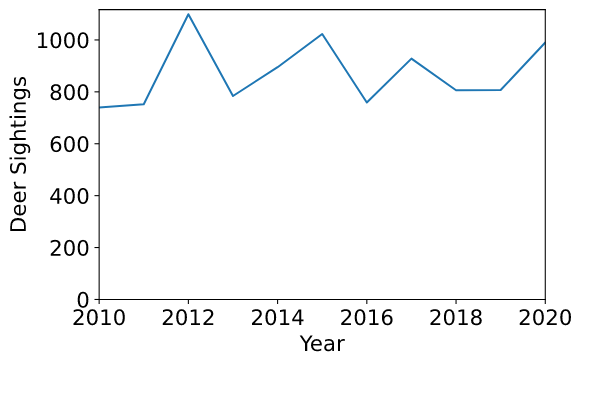

In [19]:
visit("http://127.0.0.1:5000/animal.svg?type=Deer")

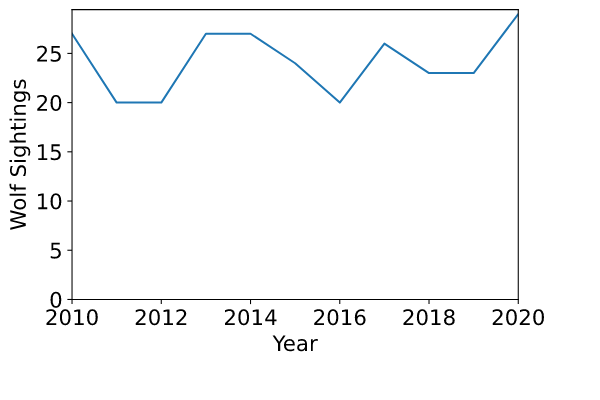

In [20]:
visit("http://127.0.0.1:5000/animal.svg?type=Wolf")

In [21]:
p.terminate()

## Multiple Resources

Visiting an HTML page rarely involves a single request to a server for a ".html" resource.  That will be the first step, but if that HTML contains something like `<img src="some_fig.svg">`, the browser will send a followup request to also grab "some_fig.svg".

In the following example, the "/" route maps to some HTML for the home page that contains three images ("/animal.svg", with various query strings).  Visiting that home page will therefore involve four requests to the server

In [22]:
from io import BytesIO

app2 = Flask("example-server")

@app2.route("/")
def home():
    return """
    <html>
    <body bgcolor="lightblue">
    <h1>Animal Sightings</h1>
    <img src="animal.svg?type=Bear"><br><br>
    <img src="animal.svg?type=Deer"><br><br>
    <img src="animal.svg?type=Wolf">
    </body>
    </html>
    """

@app2.route("/animal.svg")
def animal():
    animal = request.args["type"]

    fig, ax = plt.subplots(figsize=(3,1.5))
    ax = df[animal].plot.line(ylim=0, xlim=(2010, 2020), ax=ax)
    ax.set_xlabel("Year")
    ax.set_ylabel(f"{animal} Sightings")
    fake_file = BytesIO()
    ax.get_figure().savefig(fake_file, format="svg", bbox_inches="tight")
    return Response(fake_file.getvalue(),
                    headers={"Content-Type": "image/svg+xml"})

p = Process(target=app2.run)
p.start()
time.sleep(1) # give it time to get going

 * Serving Flask app "example-server" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [26/Feb/2021 09:35:26] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [26/Feb/2021 09:35:27] "GET /animal.svg?type=Wolf HTTP/1.1" 200 -
127.0.0.1 - - [26/Feb/2021 09:35:27] "GET /animal.svg?type=Bear HTTP/1.1" 200 -
127.0.0.1 - - [26/Feb/2021 09:35:27] "GET /animal.svg?type=Deer HTTP/1.1" 200 -


The result of these four requests will be a nice view of a single page with both text (from the HTML) and images (from the three SVGs).

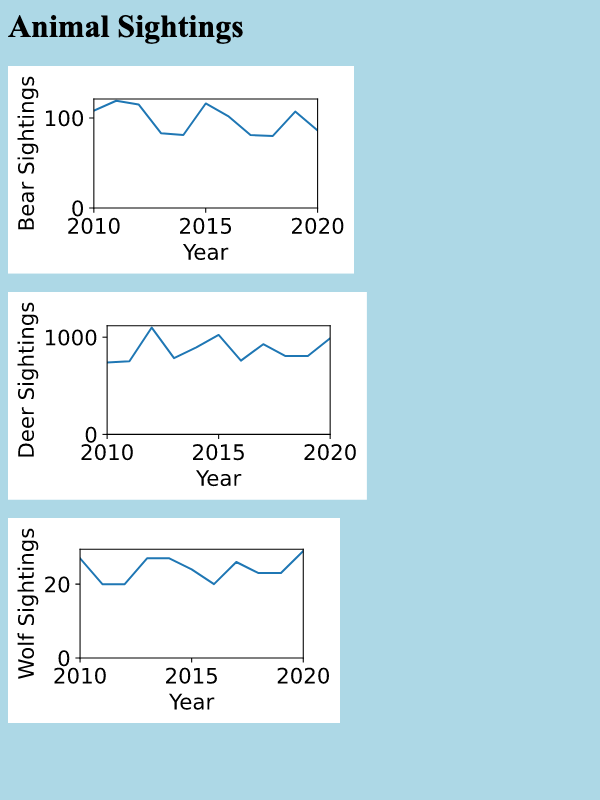

In [23]:
visit("http://127.0.0.1:5000/", height=800)

Chrome (and every major browser) has "Debug Tools" that can show you details about any given webpage.  If we were to open this and visit our flask application on port 5000, we will see those four network network requests.

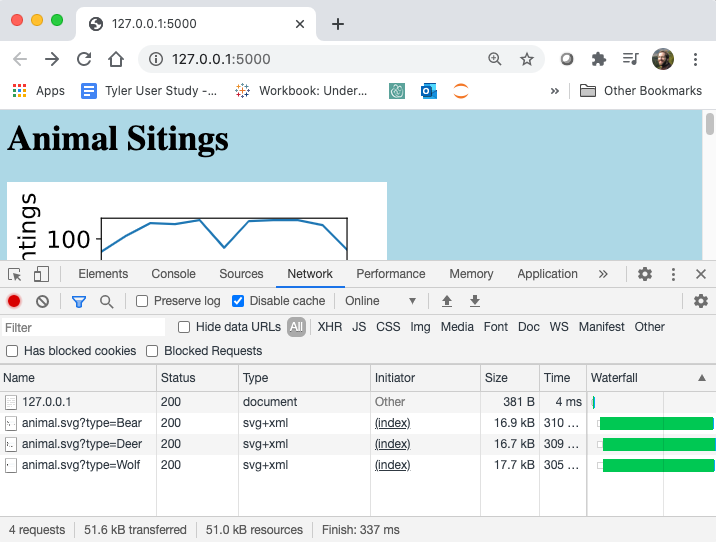

In [24]:
Image("chrome-debug.png")

In [25]:
p.terminate()

## Conclusion

A dashboard is a website with plots than are dynamically created by the server.  SVG is one common format for those plots.  In this reading, we saw that we can create flask routes for types other than HTML, such as SVGs.  We just need to make sure we create Response objects with the "Content-Type" in the header because browsers ignore the extensions (".html", ".svg", etc).